In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ted-talks/transcripts.csv
/kaggle/input/ted-talks/ted_main.csv


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
from wordcloud import WordCloud, STOPWORDS

## The Main TED Dataset 

In [3]:
df = pd.read_csv('/kaggle/input/ted-talks/ted_main.csv')
df

comments                                        description  duration  \
0         4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1          265  With the same humor and humanity he exuded in ...       977   
2          124  New York Times columnist David Pogue takes aim...      1286   
3          200  In an emotionally charged talk, MacArthur-winn...      1116   
4          593  You've never seen data presented like this. Wi...      1190   
...        ...                                                ...       ...   
2545        17  Between 2008 and 2016, the United States depor...       476   
2546         6  How can you study Mars without a spaceship? He...       290   
2547        10  Science fiction visions of the future show us ...       651   
2548        32  In an unmissable talk about race and politics ...      1100   
2549         8  With more than half of the world population li...       519   

             event   film_date  languages         main_speaker  \
0          TED2006  1140825600         60         Ken Robinson   
1          TED2006  1140825600         43              Al Gore   
2          TED2006  1140739200         26          David Pogue   
3          TED2006  1140912000         35        Majora Carter   
4          TED2006  1140566400         48         Hans Rosling   
...            ...         ...        ...                  ...   
2545       TED2017  1496707200          4     Duarte Geraldino   
2546       TED2017  1492992000          3  Armando Azua-Bustos   
2547       TED2017  1492992000          1       Radhika Nagpal   
2548  TEDxMileHigh  1499472000          1     Theo E.J. Wilson   
2549       TED2017  1492992000          1    Karoliina Korppoo   

                                                   name  num_speaker  \
0             Ken Robinson: Do schools kill creativity?            1   
1                  Al Gore: Averting the climate crisis            1   
2                         David Pogue: Simplicity sells            1   
3                    Majora Carter: Greening the ghetto            1   
4         Hans Rosling: The best stats you've ever seen            1   
...                                                 ...          ...   
2545  Duarte Geraldino: What we're missing in the de...            1   
2546  Armando Azua-Bustos: The most Martian place on...            1   
2547  Radhika Nagpal: What intelligent machines can ...            1   
2548  Theo E.J. Wilson: A black man goes undercover ...            1   
2549  Karoliina Korppoo: How a video game might help...            1   

      published_date                                            ratings  \
0         1151367060  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1         1151367060  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2         1151367060  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3         1151367060  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4         1151440680  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   
...              ...                                                ...   
2545      1505851216  [{'id': 3, 'name': 'Courageous', 'count': 24},...   
2546      1505919737  [{'id': 22, 'name': 'Fascinating', 'count': 32...   
2547      1506006095  [{'id': 1, 'name': 'Beautiful', 'count': 14}, ...   
2548      1506024042  [{'id': 11, 'name': 'Longwinded', 'count': 3},...   
2549      1506092422  [{'id': 21, 'name': 'Unconvincing', 'count': 2...   

                                          related_talks  \
0     [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1     [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2     [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3     [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4     [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   
...                                                 ...   
2545  [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...   
2546  [{'id': 2491, 'hero'

In [4]:
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

### # Features Available
* **name**: The official name of the TED Talk. Includes the title and the speaker.
* **title**: The title of the talk
* **description**: A blurb of what the talk is about.
* **main_speaker**: The first named speaker of the talk.
* **speaker_occupation**: The occupation of the main speaker.
* **num_speaker**: The number of speakers in the talk.
* **duration**: The duration of the talk in seconds.
* **event**: The TED/TEDx event where the talk took place.
* **film_date**: The Unix timestamp of the filming.
* **published_date**: The Unix timestamp for the publication of the talk on TED.com
* **comments**: The number of first level comments made on the talk.
* **tags**: The themes associated with the talk.
* **languages**: The number of languages in which the talk is available.
* **rating**: A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.)
* **related_talks**: A list of dictionaries of recommended talks to watch next.
* **url**: The URL of the talk.
* **views**: The number of views on the talk

### # Reorder the columns

In [5]:
df = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]

### # Convert the Unix timestamps into a human redable format

In [6]:
import datetime
# datetime.datetime.fromtimestamp(df.film_date[0]) # datetime.datetime(2006, 2, 25, 0, 0)
datetime.datetime.fromtimestamp(df.film_date[0]).strftime(('%d-%m-%Y')) #'25-02-2006'

'25-02-2006'

In [7]:
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))

In [8]:
df.head()

name  \
0      Ken Robinson: Do schools kill creativity?   
1           Al Gore: Averting the climate crisis   
2                  David Pogue: Simplicity sells   
3             Majora Carter: Greening the ghetto   
4  Hans Rosling: The best stats you've ever seen   

                             title  \
0      Do schools kill creativity?   
1      Averting the climate crisis   
2                 Simplicity sells   
3              Greening the ghetto   
4  The best stats you've ever seen   

                                         description   main_speaker  \
0  Sir Ken Robinson makes an entertaining and pro...   Ken Robinson   
1  With the same humor and humanity he exuded in ...        Al Gore   
2  New York Times columnist David Pogue takes aim...    David Pogue   
3  In an emotionally charged talk, MacArthur-winn...  Majora Carter   
4  You've never seen data presented like this. Wi...   Hans Rosling   

                     speaker_occupation  num_speaker  duration    event  \
0                       Author/educator            1      1164  TED2006   
1                      Climate advocate            1       977  TED2006   
2                  Technology columnist            1      1286  TED2006   
3    Activist for environmental justice            1      1116  TED2006   
4  Global health expert; data visionary            1      1190  TED2006   

    film_date published_date  comments  \
0  25-02-2006     27-06-2006      4553   
1  25-02-2006     27-06-2006       265   
2  24-02-2006     27-06-2006       124   
3  26-02-2006     27-06-2006       200   
4  22-02-2006     27-06-2006       593   

                                                tags  languages  \
0  ['children', 'creativity', 'culture', 'dance',...         60   
1  ['alternative energy', 'cars', 'climate change...         43   
2  ['computers', 'entertainment', 'interface desi...         26   
3  ['MacArthur grant', 'activism', 'business', 'c...         35   
4  ['Africa', 'Asia', 'Google', 'demo', 'economic...         48   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2  [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3  [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4  [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   

                                                 url     views  
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  
1  https://www.ted.com/talks/al_gore_on_averting_...   3200520  
2  https://www.ted.com/talks/david_pogue_says_sim...   1636292  
3  https://www.ted.com/talks/majora_carter_s_tale...   1697550  
4  https://www.ted.com/talks/hans_rosling_shows_t...  12005869

In [9]:
df.shape

(2550, 17)

## Basic EDA 

### # views

**15 Most Viewed Talks of All Time**

In [10]:
pop_talks = df[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False)[:15]
pop_talks

title       main_speaker  \
0                           Do schools kill creativity?       Ken Robinson   
1346           Your body language may shape who you are          Amy Cuddy   
677                    How great leaders inspire action        Simon Sinek   
837                          The power of vulnerability        Brené Brown   
452              10 things you didn't know about orgasm         Mary Roach   
1776         How to speak so that people want to listen    Julian Treasure   
201                                My stroke of insight  Jill Bolte Taylor   
5                                  Why we do what we do       Tony Robbins   
2114  This is what happens when you reply to spam email       James Veitch   
1416  Looks aren't everything. Believe me, I'm a model.    Cameron Russell   
500                            The puzzle of motivation           Dan Pink   
1163                            The power of introverts         Susan Cain   
1036                                 How to spot a liar       Pamela Meyer   
2109  What makes a good life? Lessons from the longe...   Robert Waldinger   
1129                    The happy secret to better work        Shawn Achor   

         views   film_date  
0     47227110  25-02-2006  
1346  43155405  26-06-2012  
677   34309432  17-09-2009  
837   31168150  06-06-2010  
452   22270883  06-02-2009  
1776  21594632  10-06-2013  
201   21190883  27-02-2008  
5     20685401  02-02-2006  
2114  20475972  08-12-2015  
1416  19787465  27-10-2012  
500   18830983  24-07-2009  
1163  17629275  28-02-2012  
1036  16861578  13-07-2011  
2109  16601927  14-11-2015  
1129  16209727  11-05-2011

In [11]:
pop_talks = df[['title', 'main_speaker', 'views', 'film_date']].sort_values('views', ascending=False)[:15]
pop_talks

title       main_speaker  \
0                           Do schools kill creativity?       Ken Robinson   
1346           Your body language may shape who you are          Amy Cuddy   
677                    How great leaders inspire action        Simon Sinek   
837                          The power of vulnerability        Brené Brown   
452              10 things you didn't know about orgasm         Mary Roach   
1776         How to speak so that people want to listen    Julian Treasure   
201                                My stroke of insight  Jill Bolte Taylor   
5                                  Why we do what we do       Tony Robbins   
2114  This is what happens when you reply to spam email       James Veitch   
1416  Looks aren't everything. Believe me, I'm a model.    Cameron Russell   
500                            The puzzle of motivation           Dan Pink   
1163                            The power of introverts         Susan Cain   
1036                                 How to spot a liar       Pamela Meyer   
2109  What makes a good life? Lessons from the longe...   Robert Waldinger   
1129                    The happy secret to better work        Shawn Achor   

         views   film_date  
0     47227110  25-02-2006  
1346  43155405  26-06-2012  
677   34309432  17-09-2009  
837   31168150  06-06-2010  
452   22270883  06-02-2009  
1776  21594632  10-06-2013  
201   21190883  27-02-2008  
5     20685401  02-02-2006  
2114  20475972  08-12-2015  
1416  19787465  27-10-2012  
500   18830983  24-07-2009  
1163  17629275  28-02-2012  
1036  16861578  13-07-2011  
2109  16601927  14-11-2015  
1129  16209727  11-05-2011

<AxesSubplot:xlabel='abbr', ylabel='views'>

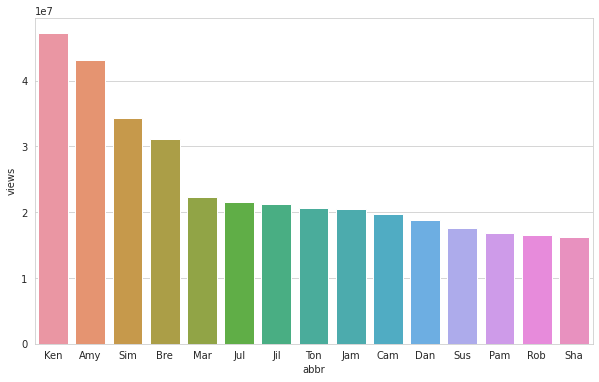

In [12]:
pop_talks['abbr'] = pop_talks['main_speaker'].apply(lambda x:x[:3])
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='abbr', y='views', data=pop_talks)

In [13]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='views', ylabel='Density'>

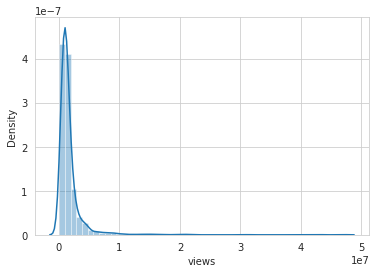

In [14]:
sns.distplot(df['views']) # This function will be removed

<AxesSubplot:xlabel='views', ylabel='Density'>

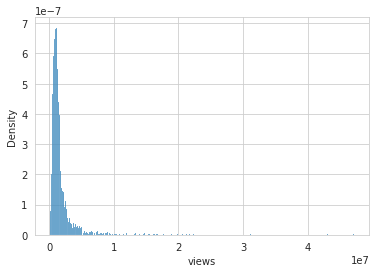

In [15]:
sns.histplot(data=df, x='views', stat='density')

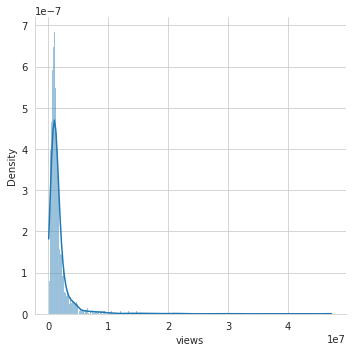

In [16]:
sns.displot(data=df, x='views', stat='density', kde=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='views', ylabel='Density'>

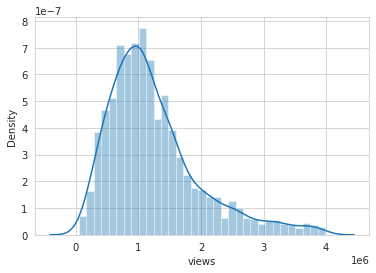

In [17]:
sns.distplot(df[df['views'] < 0.4e7]['views'])

<AxesSubplot:xlabel='views', ylabel='Density'>

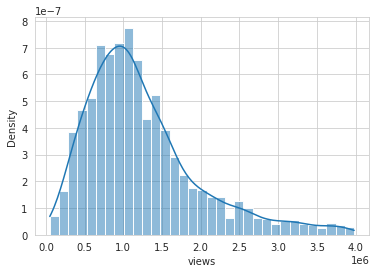

In [18]:
sns.histplot(data=df[df['views'] < 0.4e7], x='views', stat='density', kde=True)

In [19]:
df['views'].describe()

count    2.550000e+03
mean     1.698297e+06
std      2.498479e+06
min      5.044300e+04
25%      7.557928e+05
50%      1.124524e+06
75%      1.700760e+06
max      4.722711e+07
Name: views, dtype: float64

### # comments

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='comments', ylabel='Density'>

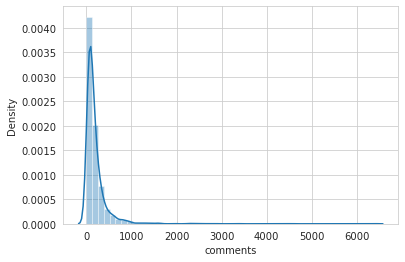

In [20]:
sns.distplot(df['comments'])

<AxesSubplot:xlabel='comments', ylabel='Density'>

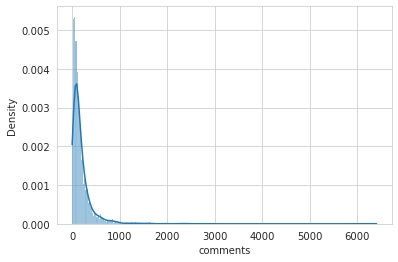

In [21]:
sns.histplot(data=df, x='comments', stat='density', kde=True)

<AxesSubplot:xlabel='comments', ylabel='Density'>

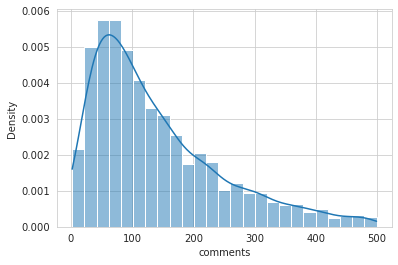

In [22]:
sns.histplot(data=df[df['comments'] < 500], x='comments', stat='density', kde=True)

In [23]:
df.comments.describe()

count    2550.000000
mean      191.562353
std       282.315223
min         2.000000
25%        63.000000
50%       118.000000
75%       221.750000
max      6404.000000
Name: comments, dtype: float64

**Let us find out that more popular videos tend to have more comments.**

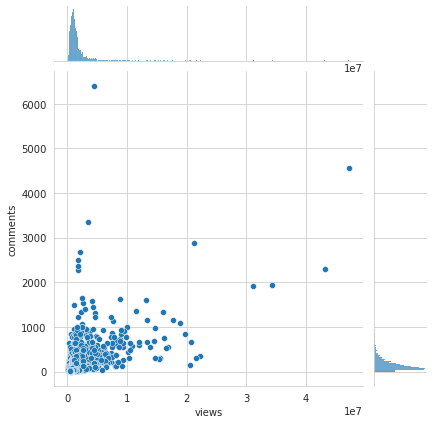

In [24]:
sns.jointplot(x='views', y='comments', data=df)

In [25]:
df[['views', 'comments']].corr()

views  comments
views     1.000000  0.530939
comments  0.530939  1.000000

As the scatterplot and the correlation matrix show, the pearson coefficient is **slightly more than 0.5**. This suggests a **medium to strong correlation** between the two quantities. This result was pretty expected as mentioned above.

**Let us now check the number of views and comments on the 10 most commented TED Talks of all time.**

In [26]:
df[['title', 'main_speaker','views', 'comments']].sort_values('comments', ascending=False).head(10)

title       main_speaker     views  \
96                            Militant atheism    Richard Dawkins   4374792   
0                  Do schools kill creativity?       Ken Robinson  47227110   
644         Science can answer moral questions         Sam Harris   3433437   
201                       My stroke of insight  Jill Bolte Taylor  21190883   
1787         How do you explain consciousness?     David Chalmers   2162764   
954               Taking imagination seriously     Janet Echelman   1832930   
840                       On reading the Koran    Lesley Hazleton   1847256   
1346  Your body language may shape who you are          Amy Cuddy  43155405   
661               The danger of science denial    Michael Specter   1838628   
677           How great leaders inspire action        Simon Sinek  34309432   

      comments  
96        6404  
0         4553  
644       3356  
201       2877  
1787      2673  
954       2492  
840       2374  
1346      2290  
661       2272  
677       1930

As can be seen above, Richard Dawkins' talk on Militant Atheism' generated the greatest amount of discussion and opinions despite having significantly lesser views than Ken Robinson's talk, which is second in the list. This raises some interesting questions.

Which talks tend to attract the largest amount of discussion?

To answer this question, we will define a new feature **discussion quotient** which is simply the ratio of the number of comments to the number of views. We will then check which talks have the largest discussion quotient.

In [27]:
df['dis_quo'] = df['comments']/df['views']

In [28]:
df[['title', 'main_speaker','views', 'comments', 'dis_quo', 'film_date']].sort_values('dis_quo', ascending=False).head(10)

title           main_speaker    views  \
744        The case for same-sex marriage        Diane J. Savino   292395   
803                E-voting without fraud          David Bismark   543551   
96                       Militant atheism        Richard Dawkins  4374792   
694   Inside a school for suicide bombers  Sharmeen Obaid-Chinoy  1057238   
954          Taking imagination seriously         Janet Echelman  1832930   
840                  On reading the Koran        Lesley Hazleton  1847256   
876          Curating humanity's heritage      Elizabeth Lindsey   439180   
1787    How do you explain consciousness?         David Chalmers  2162764   
661          The danger of science denial        Michael Specter  1838628   
561             Dance to change the world       Mallika Sarabhai   481834   

      comments   dis_quo   film_date  
744        649  0.002220  02-12-2009  
803        834  0.001534  14-07-2010  
96        6404  0.001464  02-02-2002  
694       1502  0.001421  10-02-2010  
954       2492  0.001360  03-03-2011  
840       2374  0.001285  10-10-2010  
876        555  0.001264  08-12-2010  
1787      2673  0.001236  18-03-2014  
661       2272  0.001236  11-02-2010  
561        595  0.001235  04-11-2009

### # Analysing TED Talks by the month and the year

In [29]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [30]:
print(df['film_date'][0])
print(int(df['film_date'][0].split('-')[1]))
month_order[int(df['film_date'][0].split('-')[1])-1]

25-02-2006
2


'Feb'

In [31]:
df['month'] = df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1])
df.month

0       Feb
1       Feb
2       Feb
3       Feb
4       Feb
       ... 
2545    Jun
2546    Apr
2547    Apr
2548    Jul
2549    Apr
Name: month, Length: 2550, dtype: object

In [32]:
month_df = pd.DataFrame(df['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']
month_df

month  talks
0    Feb    601
1    Mar    397
2    Jun    270
3    Jul    253
4    Nov    232
5    Oct    208
6    Apr    173
7    Dec    123
8    May    123
9    Sep    107
10   Jan     33
11   Aug     30

<AxesSubplot:xlabel='month', ylabel='talks'>

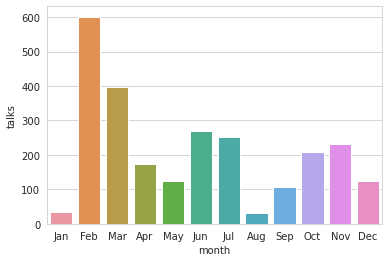

In [33]:
sns.barplot(x='month', y='talks', data=month_df, order=month_order)

**Let us check the distribution for TEDx talks only.**

In [34]:
df.event.value_counts()

TED2014                     84
TED2009                     83
TED2013                     77
TED2016                     77
TED2015                     75
                            ..
TEDxFiDiWomen                1
LIFT 2007                    1
TEDxSanJoseCA                1
TEDxLondonBusinessSchool     1
TEDxFulbrightDublin          1
Name: event, Length: 355, dtype: int64

In [35]:
df_x = df[df['event'].str.contains('TEDx')]
x_month_df = pd.DataFrame(df_x['month'].value_counts().reset_index())
x_month_df.columns = ['month', 'talks']
x_month_df

month  talks
0    Nov     95
1    Oct     65
2    Apr     55
3    Sep     51
4    May     43
5    Jun     36
6    Mar     32
7    Dec     30
8    Feb     23
9    Jan     20
10   Jul     12
11   Aug      9

<AxesSubplot:xlabel='month', ylabel='talks'>

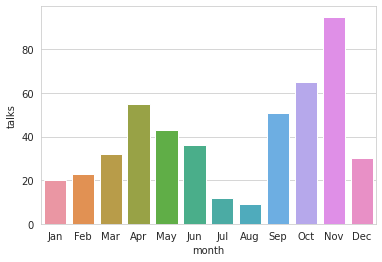

In [36]:
sns.barplot(x='month', y='talks', data=x_month_df, order=month_order)

**Let us find out that the most popular days for conducting TED and TEDx conferences.**

In [37]:
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [38]:
def getday(x):
    day, month, year = (int(i) for i in x.split('-'))    
    answer = datetime.date(year, month, day).weekday()
    return day_order[answer]

In [39]:
df['day'] = df['film_date'].apply(getday)
df.day

0       Sat
1       Sat
2       Fri
3       Sun
4       Wed
       ... 
2545    Tue
2546    Mon
2547    Mon
2548    Sat
2549    Mon
Name: day, Length: 2550, dtype: object

In [40]:
day_df = pd.DataFrame(df['day'].value_counts()).reset_index()
day_df.columns = ['day', 'talks']
day_df

day  talks
0  Thu    551
1  Wed    534
2  Fri    386
3  Sat    336
4  Tue    327
5  Mon    306
6  Sun    110

<AxesSubplot:xlabel='day', ylabel='talks'>

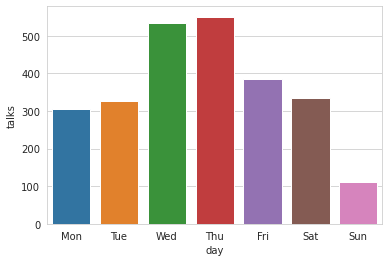

In [41]:
sns.barplot(x='day', y='talks', data=day_df, order=day_order)

**Let us now visualize the number of TED talks through the years**

In [42]:
df['year'] = df['film_date'].apply(lambda x: x.split('-')[2])
year_df = pd.DataFrame(df['year'].value_counts().reset_index())
year_df.columns = ['year', 'talks']
year_df = year_df.sort_values(by=['year'])
year_df.sort_values(by=['talks'], ascending=False)

year  talks
0   2013    270
1   2011    270
2   2012    267
3   2010    267
4   2016    246
5   2015    239
6   2014    237
7   2009    232
8   2007    114
9   2017     98
10  2008     84
11  2005     66
12  2006     50
13  2004     33
14  2003     33
15  2002     27
16  1998      6
17  2001      5
21  1983      1
22  1994      1
19  1991      1
23  1990      1
18  1984      1
20  1972      1

<AxesSubplot:xlabel='year', ylabel='talks'>

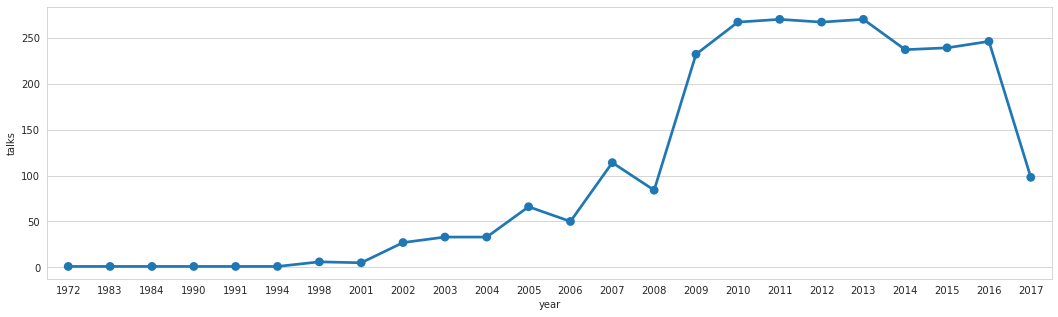

In [43]:
plt.figure(figsize=(18,5))
sns.pointplot(x='year', y='talks', data=year_df)

**Let us construct a heat map that shows us the number of talks by month and year.**

In [44]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [45]:
hmap_df = df.copy()
hmap_df['film_date'] = hmap_df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1] + " " + str(x.split('-')[2]))
hmap_df['film_date']

0       Feb 2006
1       Feb 2006
2       Feb 2006
3       Feb 2006
4       Feb 2006
          ...   
2545    Jun 2017
2546    Apr 2017
2547    Apr 2017
2548    Jul 2017
2549    Apr 2017
Name: film_date, Length: 2550, dtype: object

In [46]:
hmap_df = pd.pivot_table(hmap_df[['film_date', 'title']], index='film_date', aggfunc='count').reset_index()
hmap_df

film_date  title
0    Apr 2009      1
1    Apr 2010     27
2    Apr 2011     10
3    Apr 2012     33
4    Apr 2013     15
..        ...    ...
139  Sep 2012      9
140  Sep 2013     14
141  Sep 2014     20
142  Sep 2015     20
143  Sep 2016     15

[144 rows x 2 columns]

In [47]:
hmap_df['month_num'] = hmap_df['film_date'].apply(lambda x: months[x.split()[0]])
hmap_df['month_num']

0      4
1      4
2      4
3      4
4      4
      ..
139    9
140    9
141    9
142    9
143    9
Name: month_num, Length: 144, dtype: int64

In [48]:
hmap_df['year'] = hmap_df['film_date'].apply(lambda x: x.split()[1])
hmap_df

film_date  title  month_num  year
0    Apr 2009      1          4  2009
1    Apr 2010     27          4  2010
2    Apr 2011     10          4  2011
3    Apr 2012     33          4  2012
4    Apr 2013     15          4  2013
..        ...    ...        ...   ...
139  Sep 2012      9          9  2012
140  Sep 2013     14          9  2013
141  Sep 2014     20          9  2014
142  Sep 2015     20          9  2015
143  Sep 2016     15          9  2016

[144 rows x 4 columns]

In [49]:
hmap_df = hmap_df.sort_values(['year', 'month_num'])
hmap_df

film_date  title  month_num  year
101  May 1972      1          5  1972
60   Jul 1983      1          7  1983
30   Feb 1984      1          2  1984
84   Mar 1990      1          3  1990
18   Dec 1991      1         12  1991
..        ...    ...        ...   ...
100  Mar 2017      8          3  2017
8    Apr 2017     68          4  2017
83   Jun 2017      1          6  2017
71   Jul 2017      4          7  2017
17   Aug 2017      4          8  2017

[144 rows x 4 columns]

In [50]:
hmap_df = hmap_df[['month_num', 'year', 'title']]
hmap_df

month_num  year  title
101          5  1972      1
60           7  1983      1
30           2  1984      1
84           3  1990      1
18          12  1991      1
..         ...   ...    ...
100          3  2017      8
8            4  2017     68
83           6  2017      1
71           7  2017      4
17           8  2017      4

[144 rows x 3 columns]

In [51]:
hmap_df = hmap_df.pivot(index='month_num', columns='year', values='title').fillna(0)
hmap_df

year       1972  1983  1984  1990  1991  1994  1998  2001  2002  2003  ...  \
month_num                                                              ...   
1           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2           0.0   0.0   1.0   0.0   0.0   1.0   6.0   4.0  24.0  31.0  ...   
3           0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   3.0   2.0  ...   
4           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5           1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   
6           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
7           0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
12          0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   

year       2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  
month_num                                                              
1           1.0   0.0   3.0   6.0   2.0   7.0   3.0   2.0   4.0   3.0  
2          47.0  83.0  70.0   2.0  42.0  75.0   4.0   1.0  83.0  10.0  
3          10.0   5.0   4.0  76.0  38.0  13.0  90.0  78.0   3.0   8.0  
4           0.0   1.0  27.0  10.0  33.0  15.0   5.0   3.0  11.0  68.0  
5           8.0   2.0   6.0  17.0  18.0  15.0   4.0  35.0  16.0   0.0  
6           2.0   6.0  11.0   5.0  82.0  70.0  12.0  14.0  39.0   1.0  
7           5.0  65.0  59.0  70.0   5.0   7.0   9.0   1.0   2.0   4.0  
8           0.0   1.0   2.0   2.0   1.0   5.0   4.0  10.0   1.0   4.0  
9           1.0   7.0   7.0   9.0   9.0  14.0  20.0  20.0  15.0   0.0  
10          2.0  21.0  19.0  12.0  12.0  28.0  57.0  18.0  38.0   0.0  
11          0.0  40.0  18.0  46.0  15.0  12.0  23.0  46.0  29.0   0.0  
12          8.0   1.0  41.0  15.0  10.0   9.0   6.0  11.0   5.0   0.0  

[12 rows x 24 columns]

<AxesSubplot:xlabel='year', ylabel='month_num'>

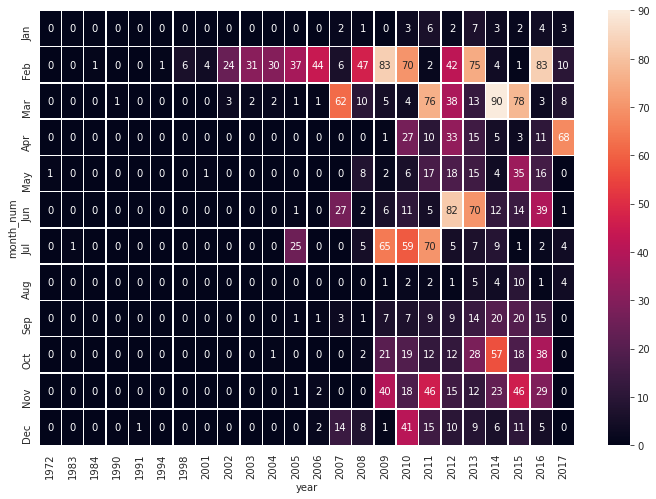

In [52]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(hmap_df, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

### # TED Speakers

**who are the most popular TED Speakers.**

In [53]:
speaker_df = df.groupby('main_speaker').count().reset_index()[['main_speaker', 'comments']]
speaker_df.columns = ['main_speaker', 'appearances']
speaker_df = speaker_df.sort_values('appearances', ascending=False)
speaker_df.head(10)

main_speaker  appearances
770           Hans Rosling            9
1066         Juan Enriquez            7
1693                 Rives            6
1278         Marco Tempest            6
397            Clay Shirky            5
1487   Nicholas Negroponte            5
1075       Julian Treasure            5
424             Dan Ariely            5
850   Jacqueline Novogratz            5
248             Bill Gates            5

### # speaker_occupation

**Which occupation should you choose if you want to become a TED Speaker?**

In [54]:
occupation_df = df.groupby('speaker_occupation').count().reset_index()[['speaker_occupation', 'comments']]
occupation_df.columns = ['occupation', 'appearances']
occupation_df = occupation_df.sort_values('appearances', ascending=False)
occupation_df

occupation  appearances
1426                                      Writer           45
83                                        Artist           34
413                                     Designer           34
753                                   Journalist           33
515                                 Entrepreneur           31
...                                          ...          ...
554                        Eye surgeon, inventor            1
553   Explorer, inventor and outer space dreamer            1
552                       Explorer, ethnographer            1
551                       Explorer and filmmaker            1
1457                                   physicist            1

[1458 rows x 2 columns]

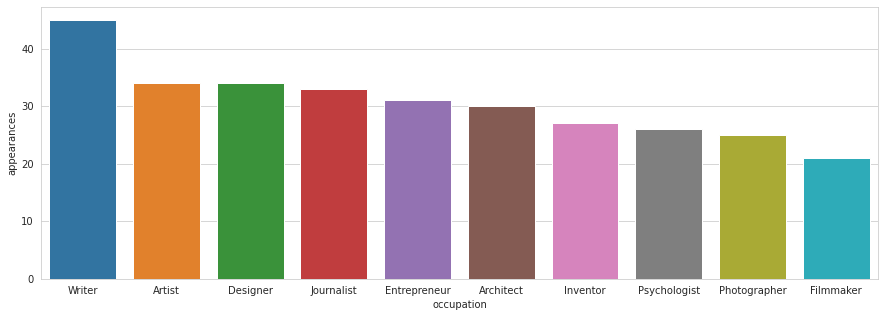

In [55]:
plt.figure(figsize=(15,5))
sns.barplot(x='occupation', y='appearances', data=occupation_df.head(10))
plt.show()

**let us visualise the relationship between the top 10 most popular professions and the views thet garnered in the form of a box plot.**

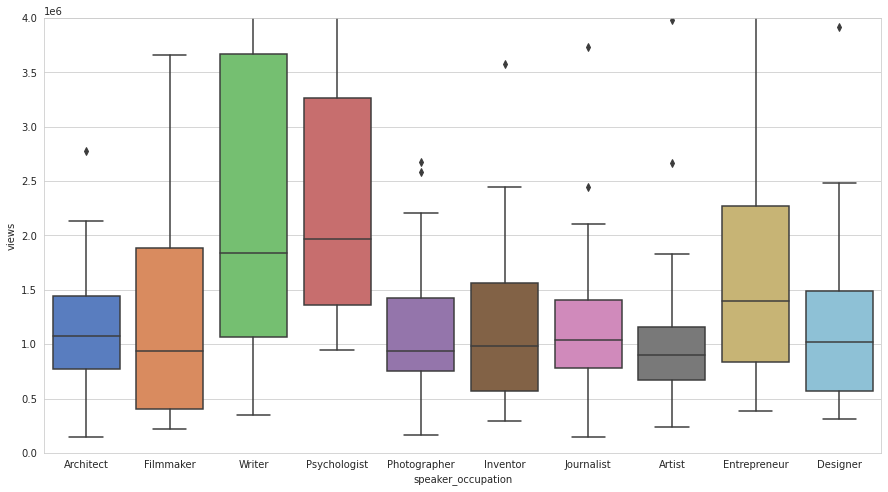

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='speaker_occupation', y='views', data=df[df['speaker_occupation'].isin(occupation_df.head(10)['occupation'])], palette="muted", ax =ax)
ax.set_ylim([0, 0.4e7])
plt.show()

### # num_speaker

In [57]:
df['num_speaker'].value_counts()

1    2492
2      49
3       5
4       3
5       1
Name: num_speaker, dtype: int64

In [58]:
df[df['num_speaker'] == 5][['title', 'description', 'main_speaker', 'event']]

title  \
2507  A dance to honor Mother Earth   

                                            description  \
2507  Movement artists Jon Boogz and Lil Buck debut ...   

                main_speaker    event  
2507  Jon Boogz and Lil Buck  TED2017

### # event

In [59]:
events_df = df[['title', 'event']].groupby('event').count().reset_index()
events_df.columns = ['event', 'talks']
events_df = events_df.sort_values('talks', ascending=False)
events_df.head(10)

event  talks
64         TED2014     84
59         TED2009     83
63         TED2013     77
66         TED2016     77
65         TED2015     75
99  TEDGlobal 2012     70
61         TED2011     70
60         TED2010     68
98  TEDGlobal 2011     68
57         TED2007     68

### # languages

In [60]:
df['languages'].describe()

count    2550.000000
mean       27.326275
std         9.563452
min         0.000000
25%        23.000000
50%        28.000000
75%        33.000000
max        72.000000
Name: languages, dtype: float64

In [61]:
df[df['languages'] == 72]

name                          title  \
973  Matt Cutts: Try something new for 30 days  Try something new for 30 days   

                                           description main_speaker  \
973  Is there something you've always meant to do, ...   Matt Cutts   

    speaker_occupation  num_speaker  duration    event   film_date  \
973       Technologist            1       207  TED2011  03-03-2011   

    published_date  ...                    tags languages  \
973     01-07-2011  ...  ['culture', 'success']        72   

                                               ratings  \
973  [{'id': 10, 'name': 'Inspiring', 'count': 6171...   

                                         related_talks  \
973  [{'id': 947, 'hero': 'https://pe.tedcdn.com/im...   

                                                   url    views   dis_quo  \
973  https://www.ted.com/talks/matt_cutts_try_somet...  8838874  0.000083   

     month  day  year  
973    Mar  Thu  2011  

[1 rows x 21 columns]

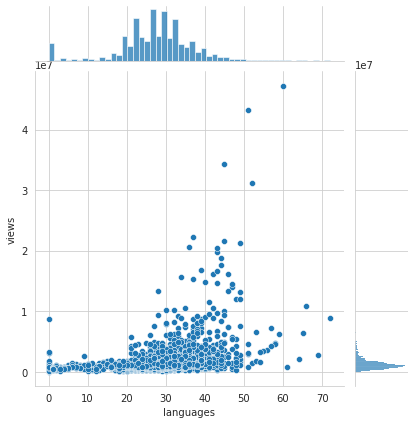

In [62]:
sns.jointplot(x='languages', y='views', data=df)
plt.show()

### # theme

**split the related_tags list**

In [63]:
import ast

df['tags'] = df['tags'].apply(lambda x : ast.literal_eval(x))

In [64]:
df.tags

0       [children, creativity, culture, dance, educati...
1       [alternative energy, cars, climate change, cul...
2       [computers, entertainment, interface design, m...
3       [MacArthur grant, activism, business, cities, ...
4       [Africa, Asia, Google, demo, economics, global...
                              ...                        
2545    [TED Residency, United States, community, fami...
2546    [Mars, South America, TED Fellows, astrobiolog...
2547    [AI, ants, fish, future, innovation, insects, ...
2548    [Internet, TEDx, United States, community, com...
2549    [cities, design, future, infrastructure, play,...
Name: tags, Length: 2550, dtype: object

In [65]:
df.tags[0][0]

'children'

In [66]:
df.apply(lambda x: pd.Series(x['tags']),axis=1)

0              1                 2               3   \
0               children     creativity           culture           dance   
1     alternative energy           cars    climate change         culture   
2              computers  entertainment  interface design           media   
3        MacArthur grant       activism          business          cities   
4                 Africa           Asia            Google            demo   
...                  ...            ...               ...             ...   
2545       TED Residency  United States         community          family   
2546                Mars  South America       TED Fellows    astrobiology   
2547                  AI           ants              fish          future   
2548            Internet           TEDx     United States       community   
2549              cities         design            future  infrastructure   

               4                   5                      6               7   \
0       education           parenting               teaching             NaN   
1     environment       global issues                science  sustainability   
2           music         performance             simplicity        software   
3     environment               green             inequality        politics   
4       economics  global development          global issues          health   
...           ...                 ...                    ...             ...   
2545  immigration          journalism          social change         society   
2546      biology         exploration  extraterrestrial life         science   
2547   innovation             insects           intelligence          robots   
2548   compassion            politics                   race             NaN   
2549         play       public spaces                society        software   

                  8           9   ...   22   23   24   25   26   27   28   29  \
0                NaN         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1         technology         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2         technology         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3          pollution         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4               math  statistics  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...              ...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2545             NaN         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2546        universe         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2547         science         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2548             NaN         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2549  urban planning         NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       30   31  
0     NaN  NaN  
1     NaN  NaN  
2     NaN  NaN  
3     NaN  NaN  
4     NaN  NaN  
...   ...  ...  
2545  NaN  NaN  
2546  NaN  NaN  
2547  NaN  NaN  
2548  NaN  NaN  
2549  NaN  NaN  

[2550 rows x 32 columns]

In [67]:
df.apply(lambda x: pd.Series(x['tags']),axis=1).stack()

0     0          children
      1        creativity
      2           culture
      3             dance
      4         education
                ...      
2549  4              play
      5     public spaces
      6           society
      7          software
      8    urban planning
Length: 19154, dtype: object

In [68]:
df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index()

level_0  level_1               0
0            0        0        children
1            0        1      creativity
2            0        2         culture
3            0        3           dance
4            0        4       education
...        ...      ...             ...
19149     2549        4            play
19150     2549        5   public spaces
19151     2549        6         society
19152     2549        7        software
19153     2549        8  urban planning

[19154 rows x 3 columns]

In [69]:
df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
# level = Only remove the given levels from the index
# use the drop parameter to avoid the old index being added as a column

0             children
0           creativity
0              culture
0                dance
0            education
             ...      
2549              play
2549     public spaces
2549           society
2549          software
2549    urban planning
Length: 19154, dtype: object

In [70]:
s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'
s

0             children
0           creativity
0              culture
0                dance
0            education
             ...      
2549              play
2549     public spaces
2549           society
2549          software
2549    urban planning
Name: theme, Length: 19154, dtype: object

In [71]:
theme_df = df.drop('tags', axis=1).join(s)
theme_df.head()

name                        title  \
0  Ken Robinson: Do schools kill creativity?  Do schools kill creativity?   
0  Ken Robinson: Do schools kill creativity?  Do schools kill creativity?   
0  Ken Robinson: Do schools kill creativity?  Do schools kill creativity?   
0  Ken Robinson: Do schools kill creativity?  Do schools kill creativity?   
0  Ken Robinson: Do schools kill creativity?  Do schools kill creativity?   

                                         description  main_speaker  \
0  Sir Ken Robinson makes an entertaining and pro...  Ken Robinson   
0  Sir Ken Robinson makes an entertaining and pro...  Ken Robinson   
0  Sir Ken Robinson makes an entertaining and pro...  Ken Robinson   
0  Sir Ken Robinson makes an entertaining and pro...  Ken Robinson   
0  Sir Ken Robinson makes an entertaining and pro...  Ken Robinson   

  speaker_occupation  num_speaker  duration    event   film_date  \
0    Author/educator            1      1164  TED2006  25-02-2006   
0    Author/educator            1      1164  TED2006  25-02-2006   
0    Author/educator            1      1164  TED2006  25-02-2006   
0    Author/educator            1      1164  TED2006  25-02-2006   
0    Author/educator            1      1164  TED2006  25-02-2006   

  published_date  ...  languages  \
0     27-06-2006  ...         60   
0     27-06-2006  ...         60   
0     27-06-2006  ...         60   
0     27-06-2006  ...         60   
0     27-06-2006  ...         60   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   

                                                 url     views   dis_quo  \
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   

   month  day  year       theme  
0    Feb  Sat  2006    children  
0    Feb  Sat  2006  creativity  
0    Feb  Sat  2006     culture  
0    Feb  Sat  2006       dance  
0    Feb  Sat  2006   education  

[5 rows x 21 columns]

In [72]:
len(theme_df['theme'].value_counts())

416

**Let us now check the most popular themes.**

In [73]:
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']
pop_themes.head(10)

theme  talks
0     technology    727
1        science    567
2  global issues    501
3        culture    486
4           TEDx    450
5         design    418
6       business    348
7  entertainment    299
8         health    236
9     innovation    229

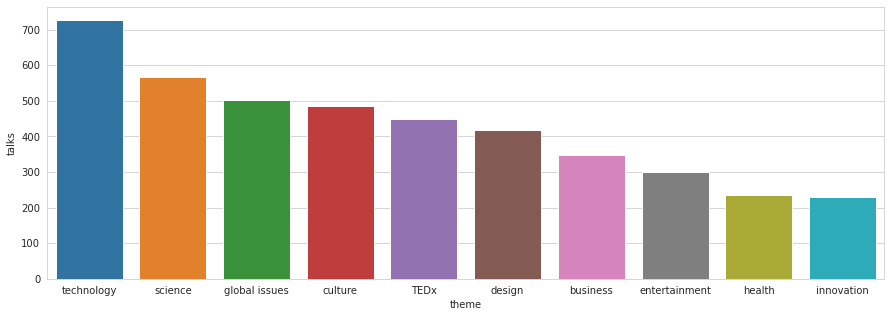

In [74]:
plt.figure(figsize=(15,5))
sns.barplot(x='theme', y='talks', data=pop_themes.head(10))
plt.show()

**We will only be considering the top 7 themes, excluding TEDx and talks after 2009, the year when the number of TED Talks really peaked.**

In [75]:
pop_theme_talks = theme_df[(theme_df['theme'].isin(pop_themes.head(8)['theme'])) & (theme_df['theme'] != 'TEDx')]
pop_theme_talks['year'] = pop_theme_talks['year'].astype('int')
pop_theme_talks = pop_theme_talks[pop_theme_talks['year'] > 2008]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
pop_theme_talks

name  \
323      Jackie Tabick: The balancing act of compassion   
324   Dayananda Saraswati: The profound journey of c...   
325        James Forbes: Compassion at the dinner table   
326   Feisal Abdul Rauf: Lose your ego, find your co...   
327   Robert Thurman: Expanding your circle of compa...   
...                                                 ...   
2541  Helen Czerski: The fascinating physics of ever...   
2543  Jun Wang: How digital DNA could help you make ...   
2546  Armando Azua-Bustos: The most Martian place on...   
2547  Radhika Nagpal: What intelligent machines can ...   
2549  Karoliina Korppoo: How a video game might help...   

                                                  title  \
323                     The balancing act of compassion   
324                  The profound journey of compassion   
325                      Compassion at the dinner table   
326                 Lose your ego, find your compassion   
327                 Expanding your circle of compassion   
...                                                 ...   
2541           The fascinating physics of everyday life   
2543  How digital DNA could help you make better hea...   
2546                    The most Martian place on Earth   
2547  What intelligent machines can learn from a sch...   
2549  How a video game might help us build better ci...   

                                            description         main_speaker  \
323   While we all agree that compassion is a great ...        Jackie Tabick   
324   Swami Dayananda Saraswati unravels the paralle...  Dayananda Saraswati   
325   Join Rev. James Forbes at the dinner table of ...         James Forbes   
326   Imam Faisal Abdul Rauf combines the teachings ...    Feisal Abdul Rauf   
327   It's hard to always show compassion -- even to...       Robert Thurman   
...                                                 ...                  ...   
2541  Physics doesn't just happen in a fancy lab -- ...        Helen Czerski   
2543  What if you could know exactly how food or med...             Jun Wang   
2546  How can you study Mars without a spaceship? He...  Armando Azua-Bustos   
2547  Science fiction visions of the future show us ...       Radhika Nagpal   
2549  With more than half of the world population li...    Karoliina Korppoo   

                       speaker_occupation  num_speaker  duration  \
323                      Spiritual leader            1       946   
324                      Vedantic teacher            1      1014   
325                              Preacher            1      1118   
326    Chairman of the Cordoba Initiative            1      1007   
327                      Buddhist scholar            1      1087   
...                                   ...          ...       ...   
2541                            Physicist            1       957   
2543                  Genomics researcher            1       894   
2546                       Astrobiologist            1       290   
2547                    Robotics engineer            1       651   
2549                        Game designer            1       519   

                         event   film_date published_date  ...  languages  \
323   TEDSalon 2009 Compassion  01-10-2009     31-10-2008  ...         30   
324     Chautauqua Institution  01-10-2009     31-10-2008  ...         38   
325     Chautauqua Institution  01-10-2009     31-10-2008  ...         20   
326   TEDSalon 2009 Compassion  14-10-2009     31-10-2008  ...         47   
327     Chautauqua Institution  01-10-2009     31-10-2008  ...         27   
...                        ...         ...            ...  ...        ...   
2541            TEDxManchester  19-02-2017     14-09-2017  ...          2   
2543                   TED2017  24-04-2017     18-09-2017  ...          1   
2546                   TED2017  24-04-2017     20-09-2017  ...          3   
2547                   TED2017  24-04-2017     21-09-2017  ...          1   
2549    

In [77]:
themes = list(pop_themes.head(8)['theme'])
themes.remove('TEDx')

In [78]:
pd.crosstab([pop_theme_talks['year']], pop_theme_talks['theme'])

theme  business  culture  design  entertainment  global issues  science  \
year                                                                      
2009         42       39      47             27             54       56   
2010         53       67      45             38             68       68   
2011         25       78      56             36             55       77   
2012         31       54      33             25             56       64   
2013         34       51      33             22             40       35   
2014         21       17      15              7             31       29   
2015         15       17      25             10             34       55   
2016         35       14      32             11             39       56   
2017          7        2      13              4             16       15   

theme  technology  
year               
2009           77  
2010           66  
2011           88  
2012           75  
2013           64  
2014           41  
2015           51  
2016           73  
2017           26

In [79]:
ctab = pd.crosstab([pop_theme_talks['year']], pop_theme_talks['theme']).apply(lambda x : x/x.sum(), axis=1)
ctab

theme  business   culture    design  entertainment  global issues   science  \
year                                                                          
2009   0.122807  0.114035  0.137427       0.078947       0.157895  0.163743   
2010   0.130864  0.165432  0.111111       0.093827       0.167901  0.167901   
2011   0.060241  0.187952  0.134940       0.086747       0.132530  0.185542   
2012   0.091716  0.159763  0.097633       0.073964       0.165680  0.189349   
2013   0.121864  0.182796  0.118280       0.078853       0.143369  0.125448   
2014   0.130435  0.105590  0.093168       0.043478       0.192547  0.180124   
2015   0.072464  0.082126  0.120773       0.048309       0.164251  0.265700   
2016   0.134615  0.053846  0.123077       0.042308       0.150000  0.215385   
2017   0.084337  0.024096  0.156627       0.048193       0.192771  0.180723   

theme  technology  
year               
2009     0.225146  
2010     0.162963  
2011     0.212048  
2012     0.221893  
2013     0.229391  
2014     0.254658  
2015     0.246377  
2016     0.280769  
2017     0.313253

In [80]:
ctab.iloc[0].sum() # 각 연도별 테마 합이 1임을 확인 

1.0

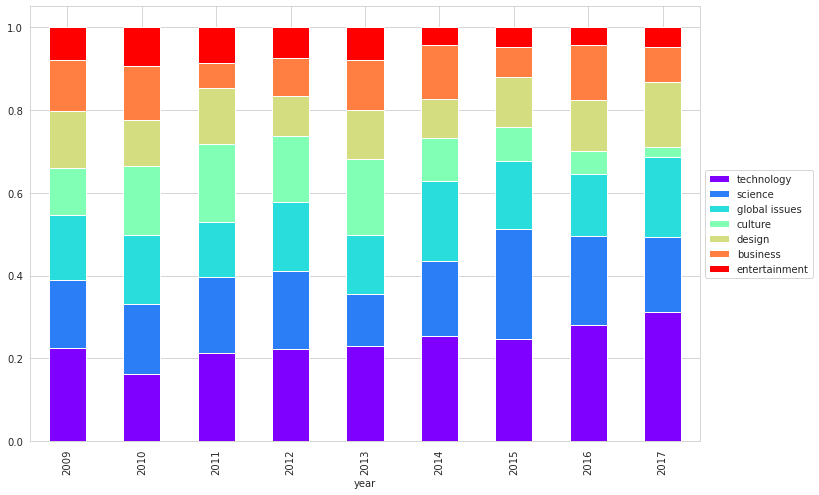

In [81]:
themes = list(pop_themes.head(8)['theme'])
themes.remove('TEDx')
ctab = pd.crosstab([pop_theme_talks['year']], pop_theme_talks['theme']).apply(lambda x: x/x.sum(), axis=1)
ctab[themes].plot(kind='bar', stacked=True, colormap='rainbow', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

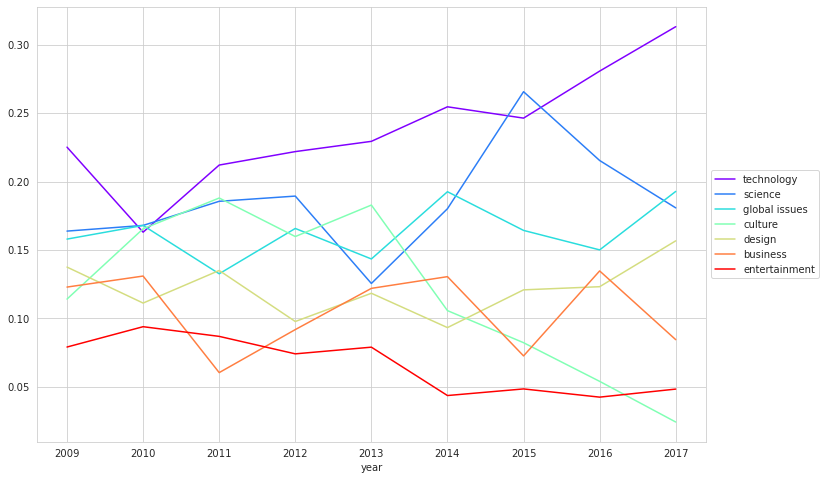

In [82]:
ctab[themes].plot(kind='line', stacked=False, colormap='rainbow', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**let us investigate if certain topics tend to garner more views than certain other topics.**

(0.0, 4000000.0)

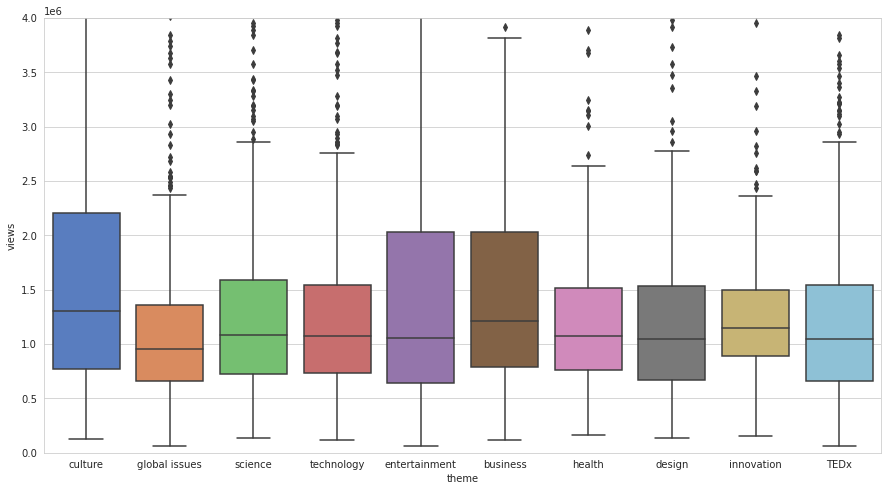

In [83]:
pop_theme_talks = theme_df[theme_df['theme'].isin(pop_themes.head(10)['theme'])]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='theme', y='views', data=pop_theme_talks, palette="muted", ax =ax)
ax.set_ylim([0, 0.4e7])

### # TED Talk Duration

In [84]:
df.duration

0       1164
1        977
2       1286
3       1116
4       1190
        ... 
2545     476
2546     290
2547     651
2548    1100
2549     519
Name: duration, Length: 2550, dtype: int64

In [85]:
#Convert to minutes
df['duration'] = df['duration']/60
df['duration'].describe()

count    2550.000000
mean       13.775170
std         6.233486
min         2.250000
25%         9.616667
50%        14.133333
75%        17.445833
max        87.600000
Name: duration, dtype: float64

**Let us look at both the shortest and the longest talk.**

In [86]:
df[df['duration'] == 2.25]

name                     title  \
239  Murray Gell-Mann: The ancestor of language  The ancestor of language   

                                           description      main_speaker  \
239  After speaking at TED2007 on elegance in physi...  Murray Gell-Mann   

    speaker_occupation  num_speaker  duration    event   film_date  \
239          Physicist            1      2.25  TED2007  03-03-2007   

    published_date  ...                                               tags  \
239     11-06-2008  ...  [culture, global issues, history, language, ph...   

    languages                                            ratings  \
239        61  [{'id': 22, 'name': 'Fascinating', 'count': 78...   

                                         related_talks  \
239  [{'id': 161, 'hero': 'https://pe.tedcdn.com/im...   

                                                   url   views   dis_quo  \
239  https://www.ted.com/talks/murray_gell_mann_on_...  785293  0.000097   

     month  day  year  
239    Mar  Sat  2007  

[1 rows x 21 columns]

In [87]:
df[df['duration'] == 87.6]

name  \
640  Douglas Adams: Parrots, the universe and every...   

                                    title  \
640  Parrots, the universe and everything   

                                           description   main_speaker  \
640  Blind river dolphins, reclusive lemurs, a parr...  Douglas Adams   

    speaker_occupation  num_speaker  duration                     event  \
640   Author, satirist            1      87.6  University of California   

      film_date published_date  ...  \
640  16-05-2001     16-03-2010  ...   

                                                  tags languages  \
640  [biodiversity, biology, comedy, humor, life, r...         0   

                                               ratings  \
640  [{'id': 22, 'name': 'Fascinating', 'count': 29...   

                                         related_talks  \
640  [{'id': 635, 'hero': 'https://pe.tedcdn.com/im...   

                                                   url   views   dis_quo  \
640  https://www.ted.com/talks/douglas_adams_parrot...  473220  0.000213   

     month  day  year  
640    May  Wed  2001  

[1 rows x 21 columns]

**Let us now check for any correlation between the popularity and the duration of a TED Talk.**  
 we will consider only those talks which have a duration less than 25 minutes.

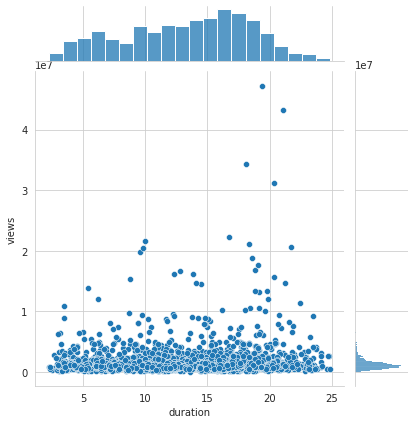

In [88]:
sns.jointplot(x='duration', y='views', data=df[df['duration'] < 25])
plt.xlabel('Duration')
plt.ylabel('Views')
plt.show()

### # Word Counts

In [89]:
df2 = pd.read_csv('/kaggle/input/ted-talks/transcripts.csv')
df2

transcript  \
0     Good morning. How are you?(Laughter)It's been ...   
1     Thank you so much, Chris. And it's truly a gre...   
2     (Music: "The Sound of Silence," Simon & Garfun...   
3     If you're here today — and I'm very happy that...   
4     About 10 years ago, I took on the task to teac...   
...                                                 ...   
2462  So, Ma was trying to explain something to me a...   
2463  This is a picture of a sunset on Mars taken by...   
2464  In my early days as a graduate student, I went...   
2465  I took a cell phone and accidentally made myse...   
2466  We humans are becoming an urban species, so ci...   

                                                    url  
0     https://www.ted.com/talks/ken_robinson_says_sc...  
1     https://www.ted.com/talks/al_gore_on_averting_...  
2     https://www.ted.com/talks/david_pogue_says_sim...  
3     https://www.ted.com/talks/majora_carter_s_tale...  
4     https://www.ted.com/talks/hans_rosling_shows_t...  
...                                                 ...  
2462  https://www.ted.com/talks/duarte_geraldino_wha...  
2463  https://www.ted.com/talks/armando_azua_bustos_...  
2464  https://www.ted.com/talks/radhika_nagpal_what_...  
2465  https://www.ted.com/talks/theo_e_j_wilson_a_bl...  
2466  https://www.ted.com/talks/karoliina_korppoo_ho...  

[2467 rows x 2 columns]

**Join of the two dataframes**

In [90]:
df3 = pd.merge(left=df,right=df2, how='left', left_on='url', right_on='url')
df3.head()

name  \
0      Ken Robinson: Do schools kill creativity?   
1           Al Gore: Averting the climate crisis   
2                  David Pogue: Simplicity sells   
3             Majora Carter: Greening the ghetto   
4  Hans Rosling: The best stats you've ever seen   

                             title  \
0      Do schools kill creativity?   
1      Averting the climate crisis   
2                 Simplicity sells   
3              Greening the ghetto   
4  The best stats you've ever seen   

                                         description   main_speaker  \
0  Sir Ken Robinson makes an entertaining and pro...   Ken Robinson   
1  With the same humor and humanity he exuded in ...        Al Gore   
2  New York Times columnist David Pogue takes aim...    David Pogue   
3  In an emotionally charged talk, MacArthur-winn...  Majora Carter   
4  You've never seen data presented like this. Wi...   Hans Rosling   

                     speaker_occupation  num_speaker   duration    event  \
0                       Author/educator            1  19.400000  TED2006   
1                      Climate advocate            1  16.283333  TED2006   
2                  Technology columnist            1  21.433333  TED2006   
3    Activist for environmental justice            1  18.600000  TED2006   
4  Global health expert; data visionary            1  19.833333  TED2006   

    film_date published_date  ...  languages  \
0  25-02-2006     27-06-2006  ...         60   
1  25-02-2006     27-06-2006  ...         43   
2  24-02-2006     27-06-2006  ...         26   
3  26-02-2006     27-06-2006  ...         35   
4  22-02-2006     27-06-2006  ...         48   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2  [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3  [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4  [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   

                                                 url     views   dis_quo  \
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  0.000096   
1  https://www.ted.com/talks/al_gore_on_averting_...   3200520  0.000083   
2  https://www.ted.com/talks/david_pogue_says_sim...   1636292  0.000076   
3  https://www.ted.com/talks/majora_carter_s_tale...   1697550  0.000118   
4  https://www.ted.com/talks/hans_rosling_shows_t...  12005869  0.000049   

   month  day  year                                         transcript  
0    Feb  Sat  2006  Good morning. How are you?(Laughter)It's been ...  
1    Feb  Sat  2006  Thank you so much, Chris. And it's truly a gre...  
2    Feb  Fri  2006  (Music: "The Sound of Silence," Simon & Garfun...  
3    Feb  Sun  2006  If you're here today — and I'm very happy that...  
4    Feb  Wed  2006  About 10 years ago, I took on the task to teac...  

[5 rows x 22 columns]

In [91]:
df3['transcript'] = df3['transcript'].fillna('')
df3['wc'] = df3['transcript'].apply(lambda x: len(x.split()))

In [92]:
df3['wc'].describe()

count    2553.000000
mean     1971.550725
std      1009.494329
min         0.000000
25%      1235.000000
50%      1983.000000
75%      2681.000000
max      9044.000000
Name: wc, dtype: float64

**We will proceed to look at a more interesting statstic: the number of words per minute.**

In [93]:
df3['wpm'] = df3['wc']/df3['duration']
df3['wpm'].describe()

count    2553.000000
mean      142.147752
std        39.635348
min         0.000000
25%       131.069182
50%       149.018182
75%       164.984615
max       247.364865
Name: wpm, dtype: float64

In [94]:
df3[df3['wpm'] > 245]

name  \
441  Mae Jemison: Teach arts and sciences together   

                                title  \
441  Teach arts and sciences together   

                                           description main_speaker  \
441  Mae Jemison is an astronaut, a doctor, an art ...  Mae Jemison   

                                    speaker_occupation  num_speaker  duration  \
441  Astronaut, engineer, entrepreneur, physician a...            1      14.8   

       event   film_date published_date  ...  \
441  TED2002  02-02-2002     05-05-2009  ...   

                                         related_talks  \
441  [{'id': 66, 'hero': 'https://pe.tedcdn.com/ima...   

                                                   url   views   dis_quo  \
441  https://www.ted.com/talks/mae_jemison_on_teach...  744257  0.000133   

    month  day  year                                         transcript    wc  \
441   Feb  Sat  2002  What I want to do today is to spend some time ...  3661   

            wpm  
441  247.364865  

[1 rows x 24 columns]

**I'd like to see if there is any correlation between words per minute and popularity.**

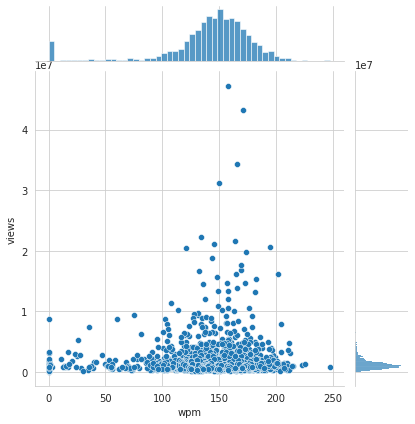

In [95]:
sns.jointplot(x='wpm', y='views', data=df3[df3['duration'] < 25])
plt.show()

### # TED Ratings

In [96]:
df.iloc[1]['ratings']

"[{'id': 7, 'name': 'Funny', 'count': 544}, {'id': 3, 'name': 'Courageous', 'count': 139}, {'id': 2, 'name': 'Confusing', 'count': 62}, {'id': 1, 'name': 'Beautiful', 'count': 58}, {'id': 21, 'name': 'Unconvincing', 'count': 258}, {'id': 11, 'name': 'Longwinded', 'count': 113}, {'id': 8, 'name': 'Informative', 'count': 443}, {'id': 10, 'name': 'Inspiring', 'count': 413}, {'id': 22, 'name': 'Fascinating', 'count': 132}, {'id': 9, 'name': 'Ingenious', 'count': 56}, {'id': 24, 'name': 'Persuasive', 'count': 268}, {'id': 23, 'name': 'Jaw-dropping', 'count': 116}, {'id': 26, 'name': 'Obnoxious', 'count': 131}, {'id': 25, 'name': 'OK', 'count': 203}]"

In [97]:
type(df.iloc[1]['ratings'])

str

In [98]:
df['ratings'] = df['ratings'].apply(lambda x: ast.literal_eval(x))

In [99]:
df.iloc[1]['ratings']

[{'id': 7, 'name': 'Funny', 'count': 544},
 {'id': 3, 'name': 'Courageous', 'count': 139},
 {'id': 2, 'name': 'Confusing', 'count': 62},
 {'id': 1, 'name': 'Beautiful', 'count': 58},
 {'id': 21, 'name': 'Unconvincing', 'count': 258},
 {'id': 11, 'name': 'Longwinded', 'count': 113},
 {'id': 8, 'name': 'Informative', 'count': 443},
 {'id': 10, 'name': 'Inspiring', 'count': 413},
 {'id': 22, 'name': 'Fascinating', 'count': 132},
 {'id': 9, 'name': 'Ingenious', 'count': 56},
 {'id': 24, 'name': 'Persuasive', 'count': 268},
 {'id': 23, 'name': 'Jaw-dropping', 'count': 116},
 {'id': 26, 'name': 'Obnoxious', 'count': 131},
 {'id': 25, 'name': 'OK', 'count': 203}]

In [100]:
type(df.iloc[1]['ratings'])

list

In [101]:
df.iloc[2]['ratings']

[{'id': 7, 'name': 'Funny', 'count': 964},
 {'id': 3, 'name': 'Courageous', 'count': 45},
 {'id': 9, 'name': 'Ingenious', 'count': 183},
 {'id': 1, 'name': 'Beautiful', 'count': 60},
 {'id': 21, 'name': 'Unconvincing', 'count': 104},
 {'id': 11, 'name': 'Longwinded', 'count': 78},
 {'id': 8, 'name': 'Informative', 'count': 395},
 {'id': 10, 'name': 'Inspiring', 'count': 230},
 {'id': 22, 'name': 'Fascinating', 'count': 166},
 {'id': 2, 'name': 'Confusing', 'count': 27},
 {'id': 25, 'name': 'OK', 'count': 146},
 {'id': 24, 'name': 'Persuasive', 'count': 230},
 {'id': 23, 'name': 'Jaw-dropping', 'count': 54},
 {'id': 26, 'name': 'Obnoxious', 'count': 142}]

In [102]:
df.iloc[110]['ratings']

[{'id': 1, 'name': 'Beautiful', 'count': 132},
 {'id': 3, 'name': 'Courageous', 'count': 136},
 {'id': 9, 'name': 'Ingenious', 'count': 43},
 {'id': 11, 'name': 'Longwinded', 'count': 21},
 {'id': 7, 'name': 'Funny', 'count': 20},
 {'id': 8, 'name': 'Informative', 'count': 347},
 {'id': 10, 'name': 'Inspiring', 'count': 363},
 {'id': 22, 'name': 'Fascinating', 'count': 78},
 {'id': 24, 'name': 'Persuasive', 'count': 176},
 {'id': 25, 'name': 'OK', 'count': 39},
 {'id': 23, 'name': 'Jaw-dropping', 'count': 42},
 {'id': 2, 'name': 'Confusing', 'count': 2},
 {'id': 21, 'name': 'Unconvincing', 'count': 2},
 {'id': 26, 'name': 'Obnoxious', 'count': 3}]

In [103]:
# 각 항목별 rating 뽑아오기 방법 1 -> list 형태로 반환

# df['funny'] = df['ratings'].apply(lambda x: [i['count'] for i in x if i['name'] == 'Funny'] if isinstance(x, list) else [0])
# df['jawdrop'] = df['ratings'].apply(lambda x: [i['count'] for i in x if i['name'] == 'jawdrop'] if isinstance(x, list) else [0])
# df['beautiful'] = df['ratings'].apply(lambda x: [i['count'] for i in x if i['name'] == 'beautiful'] if isinstance(x, list) else [0])
# df['confusing'] = df['ratings'].apply(lambda x: [i['count'] for i in x if i['name'] == 'confusing'] if isinstance(x, list) else [0])

In [104]:
# 각 항목별 rating 뽑아오기 방법 2

def get_score(x, category):
    for i in x:
        if i['name'] == category:
            return i['count']
    return 0

In [105]:
df['funny'] = df['ratings'].apply(lambda x: get_score(x, 'Funny'))
df['jawdrop'] = df['ratings'].apply(lambda x: get_score(x, 'Jaw-dropping'))
df['beautiful'] = df['ratings'].apply(lambda x: get_score(x, 'Beautiful'))
df['confusing'] = df['ratings'].apply(lambda x: get_score(x, 'Confusing'))

**Funniest Talks of all time**

In [106]:
df[['title', 'main_speaker', 'views', 'published_date', 'funny']].sort_values('funny', ascending=False)[:10]

title        main_speaker  \
0                           Do schools kill creativity?        Ken Robinson   
2114  This is what happens when you reply to spam email        James Veitch   
2161         Inside the mind of a master procrastinator           Tim Urban   
1129                    The happy secret to better work         Shawn Achor   
675   Lies, damned lies and statistics (about TEDTalks)  Sebastian Wernicke   
837                          The power of vulnerability         Brené Brown   
452              10 things you didn't know about orgasm          Mary Roach   
685                            It's time for "The Talk"       Julia Sweeney   
747    Did you hear the one about the Iranian-American?         Maz Jobrani   
692                   Bring on the learning revolution!        Ken Robinson   

         views published_date  funny  
0     47227110     27-06-2006  19645  
2114  20475972     08-01-2016   7731  
2161  14745406     15-03-2016   7445  
1129  16209727     01-02-2012   7315  
675    2212944     30-04-2010   5552  
837   31168150     23-12-2010   5225  
452   22270883     20-05-2009   4166  
685    3362099     14-05-2010   4025  
747    4646183     19-08-2010   4013  
692    7266316     24-05-2010   3000

**Most Beautiful Talks of all time**

In [107]:
df[['title', 'main_speaker', 'views', 'published_date', 'beautiful']].sort_values('beautiful', ascending=False)[:10]

title              main_speaker  \
201                          My stroke of insight         Jill Bolte Taylor   
837                    The power of vulnerability               Brené Brown   
972                    Building a park in the sky            Robert Hammond   
246   The transformative power of classical music           Benjamin Zander   
530                  The danger of a single story  Chimamanda Ngozi Adichie   
176                      Underwater astonishments               David Gallo   
0                     Do schools kill creativity?              Ken Robinson   
892               If I should have a daughter ...                 Sarah Kay   
1384                   Nature. Beauty. Gratitude.        Louie Schwartzberg   
381                  Your elusive creative genius         Elizabeth Gilbert   

         views published_date  beautiful  
201   21190883     12-03-2008       9437  
837   31168150     23-12-2010       7942  
972     704205     30-06-2011       6685  
246    9315483     25-06-2008       5967  
530   13298341     07-10-2009       5607  
176   13926113     11-01-2008       5201  
0     47227110     27-06-2006       4573  
892   10529854     18-03-2011       4430  
1384   3658158     22-11-2012       4399  
381   13155478     09-02-2009       4027

**Most Jaw Dropping Talks of all time**

In [108]:
df[['title', 'main_speaker', 'views', 'published_date', 'jawdrop']].sort_values('jawdrop', ascending=False)[:10]

title           main_speaker  \
108     How PhotoSynth can connect the world's images  Blaise Agüera y Arcas   
201                              My stroke of insight      Jill Bolte Taylor   
553  The thrilling potential of SixthSense technology          Pranav Mistry   
176                          Underwater astonishments            David Gallo   
168                     A performance of "Mathemagic"        Arthur Benjamin   
117                           New insights on poverty           Hans Rosling   
148                                    This is Saturn          Carolyn Porco   
13   The radical promise of the multi-touch interface               Jeff Han   
0                         Do schools kill creativity?           Ken Robinson   
4                     The best stats you've ever seen           Hans Rosling   

        views published_date  jawdrop  
108   4772595     27-05-2007    14728  
201  21190883     12-03-2008    10464  
553  16097077     16-11-2009     8416  
176  13926113     11-01-2008     8328  
168   8360707     13-12-2007     7196  
117   3243784     25-06-2007     5137  
148   2627709     01-10-2007     4971  
13    4531020     01-08-2006     4643  
0    47227110     27-06-2006     4439  
4    12005869     27-06-2006     3736

**Most Confusing Talks of all time**

In [109]:
df[['title', 'main_speaker', 'views', 'published_date', 'confusing']].sort_values('confusing', ascending=False)[:10]

title       main_speaker     views  \
494  I believe we evolved from aquatic apes      Elaine Morgan   1038576   
311  An 8-dimensional model of the universe       Garrett Lisi   1491698   
5                      Why we do what we do       Tony Robbins  20685401   
201                    My stroke of insight  Jill Bolte Taylor  21190883   
208                       The call to learn     Clifford Stoll   2283491   
165                      Design and destiny    Philippe Starck   1783740   
262                             Brain magic        Keith Barry  13327101   
481   17 words of architectural inspiration   Daniel Libeskind    784642   
0               Do schools kill creativity?       Ken Robinson  47227110   
29      The surprising science of happiness        Dan Gilbert  14689301   

    published_date  confusing  
494     31-07-2009        531  
311     14-10-2008        376  
5       27-06-2006        301  
201     12-03-2008        289  
208     26-03-2008        278  
165     04-12-2007        276  
262     18-07-2008        273  
481     01-07-2009        244  
0       27-06-2006        242  
29      26-09-2006        241

### # Related Videos

In [110]:
df['related_talks']

0       [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...
1       [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...
2       [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...
3       [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...
4       [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...
                              ...                        
2545    [{'id': 2596, 'hero': 'https://pe.tedcdn.com/i...
2546    [{'id': 2491, 'hero': 'https://pe.tedcdn.com/i...
2547    [{'id': 2346, 'hero': 'https://pe.tedcdn.com/i...
2548    [{'id': 2512, 'hero': 'https://pe.tedcdn.com/i...
2549    [{'id': 2682, 'hero': 'https://pe.tedcdn.com/i...
Name: related_talks, Length: 2550, dtype: object

In [111]:
df['related_talks']= df['related_talks'].apply(lambda x : ast.literal_eval(x))

In [112]:
s = df.apply(lambda x: pd.Series(x['related_talks']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'related'
s

0       {'id': 865, 'hero': 'https://pe.tedcdn.com/ima...
0       {'id': 1738, 'hero': 'https://pe.tedcdn.com/im...
0       {'id': 2276, 'hero': 'https://pe.tedcdn.com/im...
0       {'id': 892, 'hero': 'https://pe.tedcdn.com/ima...
0       {'id': 1232, 'hero': 'https://pe.tedcdn.com/im...
                              ...                        
2549    {'id': 2839, 'hero': 'https://pe.tedcdn.com/im...
2549    {'id': 1501, 'hero': 'https://pe.tedcdn.com/im...
2549    {'id': 1429, 'hero': 'https://pe.tedcdn.com/im...
2549    {'id': 1865, 'hero': 'https://pe.tedcdn.com/im...
2549    {'id': 213, 'hero': 'https://pe.tedcdn.com/ima...
Name: related, Length: 15010, dtype: object

In [113]:
df['related_talks'][0][0]

{'id': 865,
 'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
 'speaker': 'Ken Robinson',
 'title': 'Bring on the learning revolution!',
 'duration': 1008,
 'slug': 'sir_ken_robinson_bring_on_the_revolution',
 'viewed_count': 7266103}

In [114]:
related_df = df.drop('related_talks', axis=1).join(s)
related_df['related'] = related_df['related'].apply(lambda x: x['title'])
related_df['related']

0                       Bring on the learning revolution!
0                  How to escape education's death valley
0       How to fix a broken school? Lead fearlessly, l...
0                       Education innovation in the slums
0                      A short intro to the Studio School
                              ...                        
2549              7 principles for building better cities
2549    The game that can give you 10 extra years of life
2549                         The 4 commandments of cities
2549              How an obese town lost a million pounds
2549                                   A song of the city
Name: related, Length: 15010, dtype: object

In [118]:
related_df['title']

0                             Do schools kill creativity?
0                             Do schools kill creativity?
0                             Do schools kill creativity?
0                             Do schools kill creativity?
0                             Do schools kill creativity?
                              ...                        
2549    How a video game might help us build better ci...
2549    How a video game might help us build better ci...
2549    How a video game might help us build better ci...
2549    How a video game might help us build better ci...
2549    How a video game might help us build better ci...
Name: title, Length: 15010, dtype: object

In [119]:
related_df['related']

0                       Bring on the learning revolution!
0                  How to escape education's death valley
0       How to fix a broken school? Lead fearlessly, l...
0                       Education innovation in the slums
0                      A short intro to the Studio School
                              ...                        
2549              7 principles for building better cities
2549    The game that can give you 10 extra years of life
2549                         The 4 commandments of cities
2549              How an obese town lost a million pounds
2549                                   A song of the city
Name: related, Length: 15010, dtype: object

In [122]:
d = dict(related_df['title'].drop_duplicates())
d

{0: 'Do schools kill creativity?',
 1: 'Averting the climate crisis',
 2: 'Simplicity sells',
 3: 'Greening the ghetto',
 4: "The best stats you've ever seen",
 5: 'Why we do what we do',
 6: 'Letting go of God',
 7: "Behind the design of Seattle's library",
 8: "Let's teach religion -- all religion -- in schools",
 9: 'A life of purpose',
 10: 'My wish: A call for open-source architecture',
 11: 'My wish: A global day of film',
 12: 'My wish: Help me stop pandemics',
 13: 'The radical promise of the multi-touch interface',
 14: 'One Laptop per Child',
 15: "An 11-year-old's magical violin",
 16: 'Improvising on piano, aged 14',
 17: 'Simple designs to save a life',
 18: 'Organic design, inspired by nature',
 19: 'The birth of Wikipedia',
 20: 'The birth of the open-source learning revolution',
 21: 'Nerdcore comedy',
 22: 'Meet the founder of the blog revolution',
 23: 'Why we love, why we cheat',
 24: 'Happiness in body and soul',
 25: 'Chemical scum that dream of distant quasars',
 

In [123]:
d = {v: k for k, v in d.items()}

In [124]:
related_df['title'] = related_df['title'].apply(lambda x: d[x])
related_df['related'] = related_df['related'].apply(lambda x: d[x])

In [125]:
related_df['title']

0          0
0          0
0          0
0          0
0          0
        ... 
2549    2549
2549    2549
2549    2549
2549    2549
2549    2549
Name: title, Length: 15010, dtype: int64

In [126]:
related_df['related']

0        692
0       1502
0       1991
0        715
0       1023
        ... 
2549    2513
2549    1281
2549    1213
2549    1650
2549     186
Name: related, Length: 15010, dtype: int64

In [127]:
related_df = related_df[['title', 'related']]
related_df.head()

title  related
0      0      692
0      0     1502
0      0     1991
0      0      715
0      0     1023

In [128]:
edges = list(zip(related_df['title'], related_df['related']))
edges

[(0, 692),
 (0, 1502),
 (0, 1991),
 (0, 715),
 (0, 1023),
 (0, 2316),
 (1, 214),
 (1, 450),
 (1, 1825),
 (1, 2453),
 (1, 2058),
 (1, 2051),
 (2, 1488),
 (2, 1989),
 (2, 145),
 (2, 2359),
 (2, 370),
 (2, 1340),
 (3, 836),
 (3, 1644),
 (3, 1817),
 (3, 2535),
 (3, 2514),
 (3, 2513),
 (4, 1797),
 (4, 2028),
 (4, 502),
 (4, 784),
 (4, 117),
 (4, 726),
 (5, 201),
 (5, 47),
 (5, 29),
 (5, 888),
 (5, 2537),
 (5, 1996),
 (6, 43),
 (6, 8),
 (6, 685),
 (6, 95),
 (6, 9),
 (6, 260),
 (7, 603),
 (7, 1829),
 (7, 1932),
 (7, 305),
 (7, 202),
 (7, 74),
 (8, 9),
 (8, 1767),
 (8, 204),
 (8, 96),
 (8, 261),
 (8, 1114),
 (9, 8),
 (9, 326),
 (9, 1767),
 (9, 261),
 (9, 6),
 (9, 260),
 (10, 1511),
 (10, 1932),
 (10, 74),
 (10, 524),
 (10, 2281),
 (10, 231),
 (11, 1962),
 (11, 1259),
 (11, 643),
 (11, 340),
 (11, 136),
 (11, 255),
 (12, 943),
 (12, 695),
 (12, 1658),
 (12, 438),
 (12, 162),
 (12, 1923),
 (13, 553),
 (13, 698),
 (13, 1730),
 (13, 2135),
 (13, 226),
 (13, 200),
 (14, 1783),
 (14, 223),
 (14, 144

In [129]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(edges)

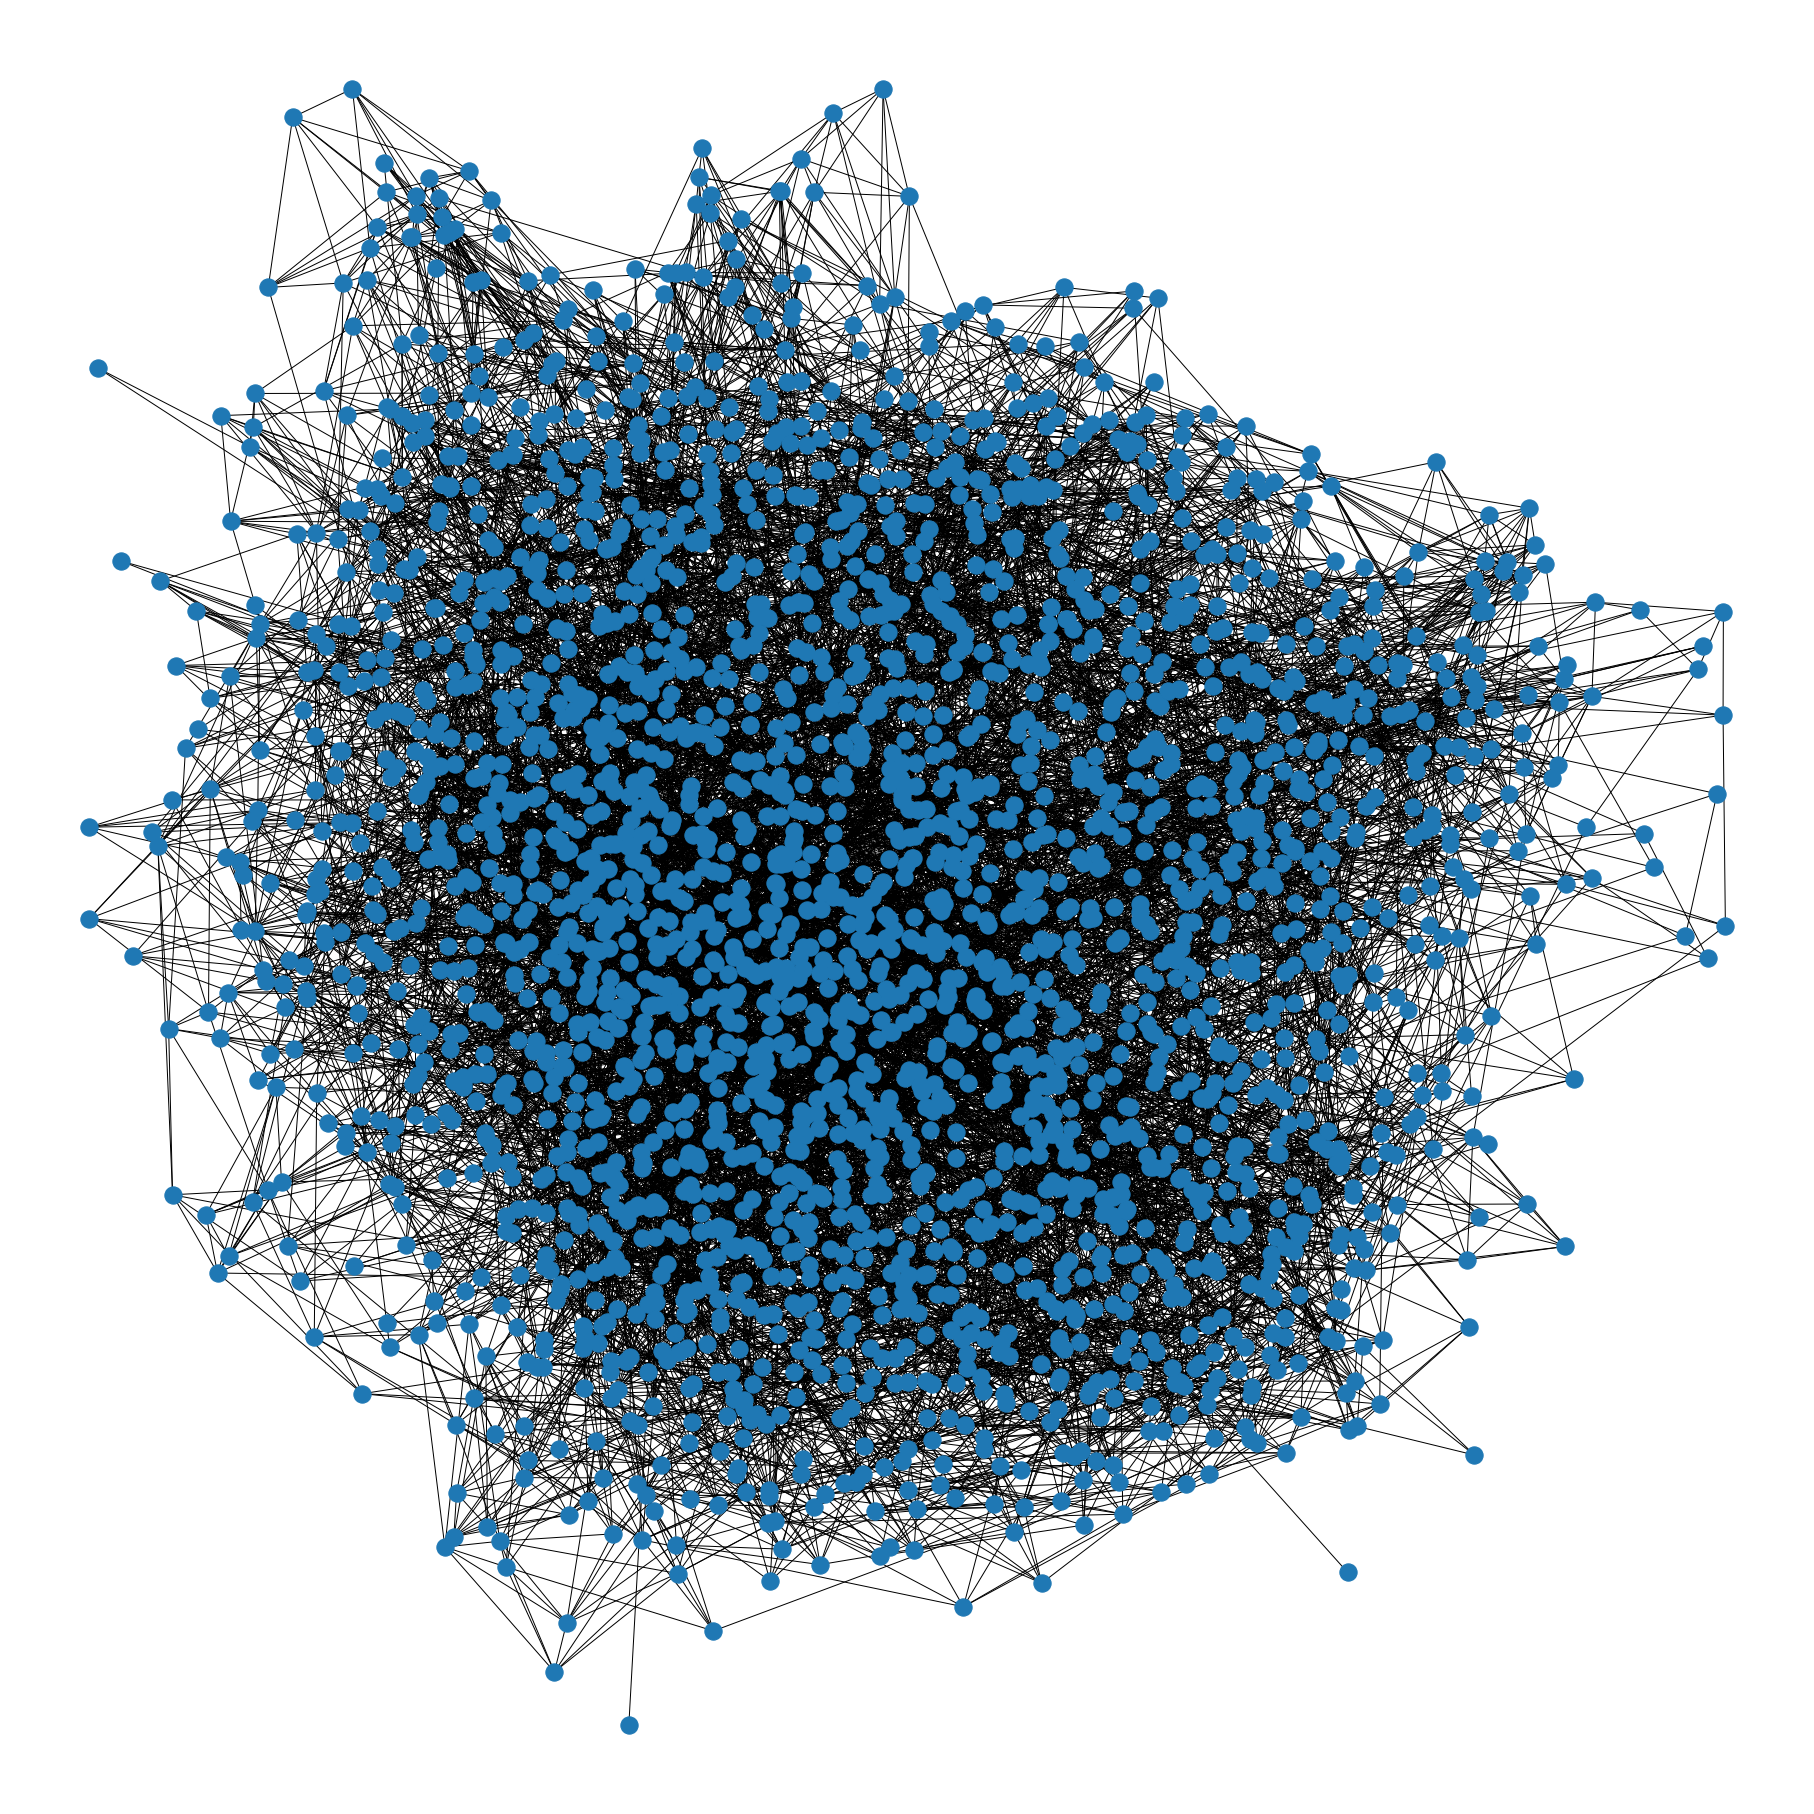

In [130]:
plt.figure(figsize=(25, 25))
nx.draw(G, with_labels=False)

### # The TED Word Cloud

In [131]:
corpus = ' '.join(df2['transcript'])
corpus = corpus.replace('.', '. ')

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(corpus)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()